# Fixture Count Example

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/FixtureCount.ipynb)

- Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and replace it below:

In [1]:
signal_ocean_api_key = ""  # replace with your subscription key

## Setup

### Import libraries and set default values

- Install the Signal Ocean SDK and import all required modules:

In [3]:
%%capture
!pip install signal-ocean

from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.voyages import VesselClass, VesselClassFilter
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import OrderedDict

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import math

# Initialize the voyage api
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

#set up the grouped areas
area_mapping = {
    'Arabian Gulf':'AG',
    'Red Sea':'AG',
    'Singapore / Malaysia':'AG',
    'Canada Atlantic Coast':'Caribs',
    'Caribs':'Caribs',
    'US Atlantic Coast':'Caribs',
    'East Coast Mexico':'USG',
    'US Gulf':'USG',
    'Africa Atlantic Coast':'WAF',
    'Argentina & Uruguay':'WAF',
    'Brazil':'WAF'
}

### Set parameters

- set  the vessel class

In [4]:
vessel_class_name_like = 'vlcc'

- set the year and month from when you want to count fixtures

In [5]:
year, month = 2021, 8

## Calculate Fixture Count

### Get fixtures

* get the voyages data using Voyage API 
* we extract the voyages which have start after 2 months before the fixture date
* from the Voyage Events we extract the Area Level 0, which will be used to create the area groups for fixtures

In [6]:
def get_voyages(vcn, year, month):
    def get_voyage_load_area(voyage_events):
        return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)
    def get_voyage_port_id(voyage_events):
        return next((e.port_id for e in voyage_events or [] if e.purpose=='Load'), None)

    #calculate the voyage start date (2 month before)
    months_back = 2
    fixture_date_from = date(year=year, month=month,day=1)
    date_from = fixture_date_from - relativedelta(months=+months_back)

    # get the vessel class id
    vc = api.get_vessel_classes(VesselClassFilter(vcn))[0]
    vessel_class_id = vc.vessel_class_id

    data = api.get_voyages(vessel_class_id=vessel_class_id, date_from=date_from)
    voyages = pd.DataFrame([v.__dict__ for v in data])
    voyages['Level0AreaName_load'] = voyages['events'].apply(get_voyage_load_area)
    voyages['port_id'] = voyages['events'].apply(get_voyage_port_id)
    voyages.rename(columns={'vessel_class_id': 'VesselClassID'}, inplace=True)
    return voyages

### Preprocess Fixtures

- We use the area_mapping dictionary we group the level 0 areas
- In order a voyage to be fixed, the laycan_from field should not be null
- We keep the voyages which has laycan_from is greater than the selected date 
- The final Step is to group the data by year, month, area, and decate and calculate the fixture count for each group

In [7]:
def preprocess(data,area_mapping):

    # Keep only the dirty
    voyages = data.copy()
    voyages = voyages[voyages.trade_id == 1]

    # merge with the area_mapping on area_level0_name and vessel_class_id
    voyages['Area'] = voyages.Level0AreaName_load.map(lambda x: area_mapping[x] 
                                                    if x in area_mapping 
                                                    else None)
    voyages_df = voyages[["imo","voyage_number","VesselClassID",
                        "Level0AreaName_load","Area","laycan_from","port_id"]]

    # filter with laycan from is not null
    voyages_df = voyages_df[~voyages_df.laycan_from.isna()]

    # filter with laycan from
    filtered_voyages = voyages_df[voyages_df.laycan_from.dt.date >= 
                                date(year=year, month=month, day=1)]

    # split the laycan from to month, date, year and create the decade
    final_df = filtered_voyages.copy()
    final_df['day'] = final_df['laycan_from'].dt.day
    final_df['month'] = final_df['laycan_from'].dt.month
    final_df['year'] = final_df['laycan_from'].dt.year

    choices = [1,2,3]
    conditions = [
        (final_df['day'] <= 10), 
        ((final_df['day'] > 10) & (final_df['day'] <= 20)),
        (final_df['day'] > 20) ]
    final_df['decade'] = np.select(conditions, choices, default=np.nan)
    final_df['decade'] = final_df['decade'].astype(int)

    # Remove nan load areas
    final_df = final_df[~final_df.Area.isna()]

    fixture_counts_df = (
    final_df
    .groupby(['month','year','Area','decade'])
    .size()
    .rename('fixture_counts')
    .reset_index()    
    )

    # this step is to help us visualize the Area with 0 fixtures 
    month_groups = set(fixture_counts_df.groupby(['year','month']) \
                                        .groups.keys())
    area_groups = set(area_mapping.values())
    area_month_groups = []
    for area in area_groups:
        for period in month_groups:
            area_month_groups.append((period[0],period[1],area))
    decate_areas = []
    for area_month in area_month_groups:
        decate_areas.append((1,area_month[0],area_month[1],area_month[2]))
        decate_areas.append((2,area_month[0],area_month[1],area_month[2]))
        decate_areas.append((3,area_month[0],area_month[1],area_month[2]))
    decate_per_area = pd.DataFrame(decate_areas, columns=['decade', 
                                                        'year','month',
                                                        'Area'])
    fixture_counts_df = pd.merge(fixture_counts_df,decate_per_area,
                               on=['decade','year','month','Area'],
                               how='right').fillna(0)
    # calculate the total fixtures
    fixture_counts_df['Area Total'] = (
    fixture_counts_df
    .groupby(['year','month','Area'])
    .fixture_counts
    .transform('sum')    
    )

    # sort the the fixture counts
    fixture_counts_df = fixture_counts_df.sort_values(
        ['year','month','Area Total','Area','decade'],
        ascending=[False,False,True,True,True,]) 
    return fixture_counts_df

### Plot Fixture Counts

In [16]:
def plot_results(fixture_counts_df):

    def get_trace(name,color,decate,show_legend):
        return go.Bar(
                    name=name,
                    x=data[data.decade==decate]["fixture_counts"],
                    y=data[data.decade==decate]["Area"],
                    orientation='h',
                    showlegend=show_legend,
                    marker={'color': color},
                    text=data[data.decade==decate]["fixture_counts"]
                )

    group_plots = fixture_counts_df.groupby(['year','month']).groups.keys()
    sorted_groups = sorted(group_plots, 
                         key=lambda element: (element[0], element[1]),
                         reverse=True)
    figures = []
    titles = []
    for i,group in enumerate(sorted_groups):
        data = fixture_counts_df[
                                 (fixture_counts_df.year==group[0])&
                                 (fixture_counts_df.month==group[1])
                                 ]
        titles.append(
            date(group[0], group[1], 1).strftime('%B') + " " + str(group[0])
            )
        show_legend = True if i == 0 else False
        fig = go.Figure(
              data=[
                get_trace("First decade (1st - 10th)", 'green', 1, show_legend),
                get_trace("Second decade (10th - 20th)", 'blue', 2, show_legend),
                get_trace("Third decade (20th - 30th)", 'red', 3, show_legend)
              ],
            )
        figures.append(fig)
        
    no_rows = math.ceil(len(sorted_groups)/2)
    specs = [[{}, {}] for _ in range(no_rows)]
    fig_subplots = make_subplots(
        rows=no_rows, cols=2,
        specs=specs,
        x_title='Fixture Counts',
        y_title='Areas',
        subplot_titles=tuple(titles),
    )

    for i,f in enumerate(figures):
        for t in f.data:
            fig_subplots.append_trace(t, row=(i//2)+1, col=(i%2)+1)

    fig_subplots['layout'].update(
      height=300*no_rows, 
      width=1400, 
      title='Fixture Counts',
      barmode='stack',
      legend_traceorder='reversed')
    fig_subplots.show()

## Results

In [9]:
# Get voyages
voyages = get_voyages(vessel_class_name_like, year, month)

In [10]:
# Preprocess fixtures
preprocessed_voyages = preprocess(voyages, area_mapping)

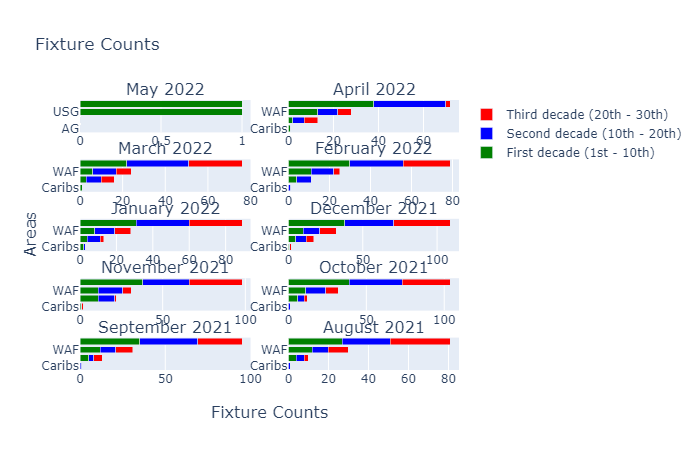

In [17]:
# Plot the results
plot_results(preprocessed_voyages)